In [1]:
import numpy as np
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
with open('data.json', 'r') as file:
        data = json.load(file)

In [3]:
training_sentences = []
training_labels = []
labels = []
responses = []

for intent in data['intents']:
    for pattern in intent['patterns']:
        training_sentences.append(pattern)
        training_labels.append(intent['tag'])
    responses.append(intent['responses'])
    
    if intent['tag'] not in labels:
        labels.append(intent['tag'])
        
num_classes = len(labels)

In [4]:
lbl_encoder = LabelEncoder()
lbl_encoder.fit(training_labels)
training_labels = lbl_encoder.transform(training_labels)
vocab_size = 1000
embedding_dim = 16
max_len = 20
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)

In [5]:
model = Sequential([
    Input(shape=(max_len,)),
    Embedding(vocab_size, embedding_dim),
    GlobalAveragePooling1D(),
    #LSTM(128, return_sequences=True),
    #LSTM(64),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 16)              │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,646 (65.02 KB)

 Trainable params: 16,646 (65.02 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% training, 20% validation)
padded_sequences_train, padded_sequences_val, labels_train, labels_val = train_test_split(
    padded_sequences, training_labels, test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    Input(shape=(max_len,)),
    Embedding(vocab_size, embedding_dim),
    GlobalAveragePooling1D(),
    #LSTM(128, return_sequences=True),
    #LSTM(64),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_accuracy',  # You can also monitor 'val_loss'
    patience= 50,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restores the model weights from the epoch with the best validation accuracy
)


# Train the model, including validation data
epochs = 200
history = model.fit(
    padded_sequences_train, 
    np.array(labels_train), 
    epochs=epochs,
    validation_data=(padded_sequences_val, np.array(labels_val)),
    
)

# Now you can access the validation accuracy from the history object

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.1420 - loss: 1.7920 - val_accuracy: 0.3488 - val_loss: 1.7868
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1887 - loss: 1.7863 - val_accuracy: 0.2907 - val_loss: 1.7796
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1866 - loss: 1.7785 - val_accuracy: 0.2907 - val_loss: 1.7737
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1824 - loss: 1.7764 - val_accuracy: 0.2907 - val_loss: 1.7678
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1733 - loss: 1.7773 - val_accuracy: 0.2907 - val_loss: 1.7640
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1990 - loss: 1.7599 - val_accuracy: 0.2907 - val_loss: 1.7588
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1881 - loss: 1.7674 - val_accuracy: 0.3837 - val_loss: 1.7546
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2832 - loss: 1.7511 - val_accuracy: 0.2907 - 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9572 - loss: 0.2452 - val_accuracy: 0.8372 - val_loss: 0.5264
Epoch 52/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9763 - loss: 0.2090 - val_accuracy: 0.8488 - val_loss: 0.5137
Epoch 53/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9720 - loss: 0.1989 - val_accuracy: 0.8372 - val_loss: 0.4946
Epoch 54/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9691 - loss: 0.1959 - val_accuracy: 0.8488 - val_loss: 0.5067
Epoch 55/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9746 - loss: 0.1726 - val_accuracy: 0.8372 - val_loss: 0.4757
Epoch 56/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9795 - loss: 0.1783 - val_accuracy: 0.8256 - val_loss: 0.5028
Epoch 57/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9715 - loss: 0.1812 - val_accuracy: 0.8256 - val_loss: 0.4612
Epoch 58/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9835 - loss: 0.1525 - val_accuracy: 0.8372 - val_lo

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.0355 - val_accuracy: 0.8605 - val_loss: 0.3317
Epoch 102/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9990 - loss: 0.0314 - val_accuracy: 0.8721 - val_loss: 0.3311
Epoch 103/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9945 - loss: 0.0379 - val_accuracy: 0.8605 - val_loss: 0.3278
Epoch 104/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9983 - loss: 0.0299 - val_accuracy: 0.8721 - val_loss: 0.3243
Epoch 105/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9919 - loss: 0.0457 - val_accuracy: 0.8605 - val_loss: 0.3312
Epoch 106/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9945 - loss: 0.0314 - val_accuracy: 0.8721 - val_loss: 0.3218
Epoch 107/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0312 - val_accuracy: 0.8605 - val_loss: 0.3204
Epoch 108/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.0318 - val_accuracy: 0.8721 -

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9967 - loss: 0.0154 - val_accuracy: 0.8721 - val_loss: 0.3065
Epoch 152/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9937 - loss: 0.0144 - val_accuracy: 0.8721 - val_loss: 0.2910
Epoch 153/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9983 - loss: 0.0192 - val_accuracy: 0.8721 - val_loss: 0.2924
Epoch 154/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9973 - loss: 0.0165 - val_accuracy: 0.8721 - val_loss: 0.3249
Epoch 155/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9885 - loss: 0.0222 - val_accuracy: 0.8837 - val_loss: 0.2860
Epoch 156/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9978 - loss: 0.0159 - val_accuracy: 0.8721 - val_loss: 0.2965
Epoch 157/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9983 - loss: 0.0168 - val_accuracy: 0.8721 - val_loss: 0.3015
Epoch 158/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9978 - loss: 0.0136 - val_accuracy: 0.8721 -

In [7]:
# Get the best training accuracy and corresponding epoch
best_accuracy = max(history.history['accuracy'])
best_accuracy_epoch = history.history['accuracy'].index(best_accuracy) + 1  # Add 1 because epochs start at 1

# Get the best validation accuracy and corresponding epoch
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy_epoch = history.history['val_accuracy'].index(best_val_accuracy) + 1  # Add 1 because epochs start at 1

# Print the results
print(f"Best Training Accuracy: {best_accuracy*100:.2f}% at epoch {best_accuracy_epoch}")
print(f"Best Validation Accuracy: {best_val_accuracy*100:.2f}% at epoch {best_val_accuracy_epoch}")


Best Training Accuracy: 99.71% at epoch 90
Best Validation Accuracy: 89.53% at epoch 185


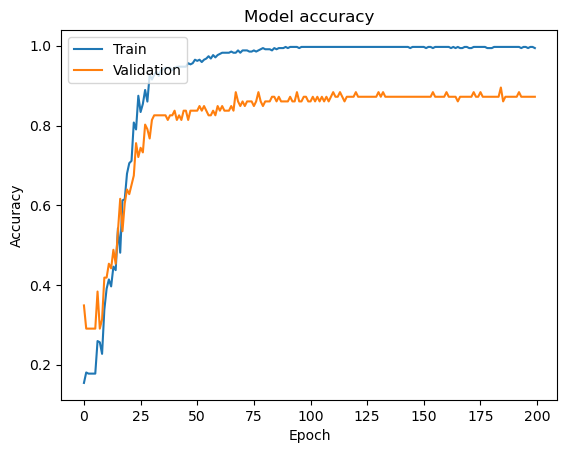

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [9]:
# to save the trained model
model.save("chat_model.keras")

import pickle

# to save the fitted tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# to save the fitted label encoder
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(lbl_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)